<a href="https://colab.research.google.com/github/akiseakusa/car_projection/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN is better suited for Image classification, I have tried out VGG16, ResNet50 and Vision Transformer**

**Initial hypothesis**

VGG16 - VGG16's deep, structured layers and transfer learning capabilities efficiently capture image features, making it ideal for accurate car angle detection with limited data.

ResNet50- ResNet models are known for their deep architecture and skip connections, which help avoid vanishing gradients in deep networks.perform well in complex classification tasks, and their deeper architecture can help capture fine details in images.


Vision Transformers- Vision Transformers are based on the Transformer architecture, which is known for its ability to capture long-range dependencies. They are good at image classification, especially when pretrained on large datasets.ViTs have recently shown state-of-the-art results in various vision tasks and may outperform CNNs in some cases.


**Result**

Vision Transformer consumes alot of resources and time, due to limited resources epoch was not completed, Therefore not included in Evaluation. But the accuracy was low in initial epochs whereas ResNet and VGG16 show fast Learning may be due to dense structure VIT require times.

Due to limited resources tested vgg16 and resnet50 for 5 epochs , vgg16 attains 88% accuracy whereas resnet has 54% accuracy the result variation is observed due to double the size of parameter.

In conclusion, if training resources are limited then no doubt vgg16 outperforms all models but where sufficient resources available for training,I prefer Resnet50 for car angle detection because it has more parameter, learn faster than vgg16 and can achieve better accuracy once trained.

In [ ]:
!pip install -q kagglehub tensorflow fastapi uvicorn pillow transformers pyngrok python-multipart nest_asyncio



# Download Dataset

In [ ]:
!kaggle datasets download amarcodes/car-angle-classification-dataset

In [ ]:
!unzip /content/car-angle-classification-dataset.zip -d /content/


# **Import Required**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pyngrok import ngrok
import nest_asyncio
import uvicorn
import logging
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16,ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Convolution2D,MaxPooling2D,Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from fastapi import FastAPI, File, UploadFile

# **Data Augmentation and Pre-processing**

In [ ]:

IMAGE_SIZE = 224

datagen = ImageDataGenerator(validation_split=0.2,
        rescale=1./255,#rescaling pixel values bw [0,1]
        rotation_range=10,#adjusting any error in angle of image
        zoom_range=0.2
)

In [ ]:


# Set the path to your dataset directory
dataset_path = "/content/dataset"

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=128,
    class_mode='sparse',  # Use 'sparse' for integer labels
    subset='training'  # Specify that this is the training set
)

test_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=128,
    class_mode='sparse',  # Use 'sparse' for integer labels
    subset='validation'  # Specify that this is the validation set
)




In [ ]:
class_names = list(train_generator.class_indices.keys())
class_names

# **Vgg_model and Resnet50 Initialization**

In [ ]:
sz = 224
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(sz, sz, 3))
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(sz, sz, 3))

In [ ]:
for layer in vgg_model.layers:
    layer.trainable = False

for layer in resnet_model.layers:
    layer.trainable = False

Vgg16 Model

In [ ]:


# Create the model
model_vgg = Sequential()

# Add an input layer
model_vgg.add(Input(shape=(224, 224, 3)))  # Explicitly define input shape

# Add the VGG16 model
model_vgg.add(vgg_model)

# Continue building the model
model_vgg.add(GlobalAveragePooling2D())  # Better than flattening when dealing with CNNs
model_vgg.add(Dense(256, activation='relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(8, activation='softmax'))

# Compile the model
model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Now you should be able to get the summary
model_vgg.summary()



# **Resnet50 Architecture**

In [ ]:
model_resnet = Sequential()

# Add an input layer
model_resnet.add(Input(shape=(224, 224, 3)))  # Explicitly define input shape

# Add the ResNet50 model
model_resnet.add(resnet_model)

# Continue building the model
model_resnet.add(GlobalAveragePooling2D())  # Better than flattening when dealing with CNNs
model_resnet.add(Dense(256, activation='relu'))
model_resnet.add(Dropout(0.5))
model_resnet.add(Dense(len(class_names), activation='softmax'))  # Ensure the number of classes matches

# Compile the model
model_resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_resnet.summary()

# **Train VGG16**

In [ ]:
vgg_train = model_vgg.fit(
    train_generator,
    validation_data=test_generator,
    epochs=5
)

# **Train ResNet50**

In [ ]:
resnet_train = model_resnet.fit(
    train_generator,
    validation_data=test_generator,
    epochs=5
)

# **Models Evaluation**

In [ ]:
scores_vgg = model_vgg.evaluate(test_generator)
scores_vgg = model_resnet.evaluate(test_generator)

# **VIT Accuracy during initial epoch but due to high resource consumption process got crashed**

In [ ]:

from transformers import ViTFeatureExtractor, TFViTForImageClassification, create_optimizer


train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='sparse',  # Integer labels
    subset='training'     # Training data subset
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='sparse',  # Integer labels
    subset='validation'   # Validation data subset
)

# Load the Vision Transformer model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
vit_model = TFViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=8,  # 8 classes for your car angle detection task
    ignore_mismatched_sizes=True  # Allow the model to adapt to the number of classes
)

# Preprocess each batch on-the-fly using a custom generator function
def preprocess_images(batch):
    images, labels = batch
    # Preprocess the images using the ViTFeatureExtractor
    images = feature_extractor(images, return_tensors='tf')['pixel_values']
    return images, labels

# Wrap the train and validation generators with preprocessing function
train_generator_with_preprocessing = map(preprocess_images, train_generator)
validation_generator_with_preprocessing = map(preprocess_images, validation_generator)

# Define optimizer using Hugging Face's utility functions
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)
num_train_steps = steps_per_epoch * 10  # 10 epochs

# Create an Adam optimizer with a linear learning rate schedule
optimizer, schedule = create_optimizer(
    init_lr=0.01,
    num_train_steps=num_train_steps,
    num_warmup_steps=0,
)

# Compile the model
vit_model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

# Train the model using the preprocessed data generators
history = vit_model.fit(
    train_generator_with_preprocessing,
    validation_data=validation_generator_with_preprocessing,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)


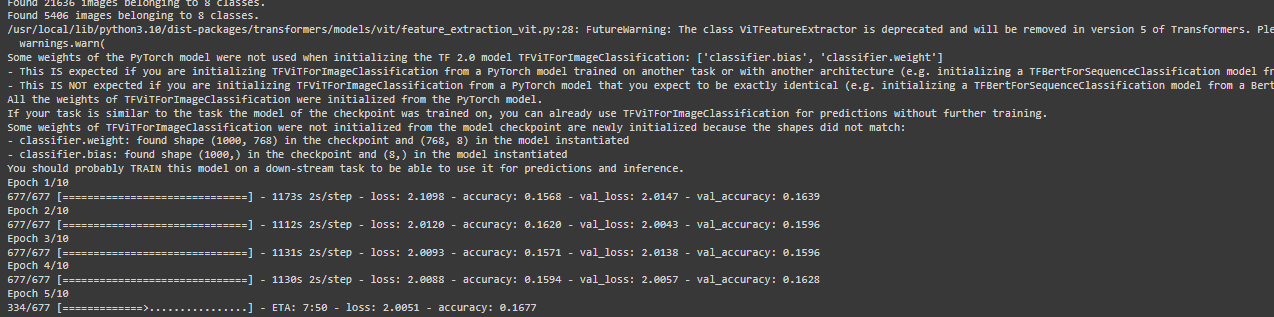

# **Fast API Code**

Add Ngrok auth token and run following cell to hit FastAPI

Note - follow the public Url as local is not connected with google colab



In [ ]:
# ngrok auth setup
!ngrok config add-authtoken 2PeK25GBPCbyhAyPrZp8kGPaALy_7njuqdZ3k5tsJRRtXmt5u

In [ ]:
from fastapi import FastAPI, File, UploadFile
from typing import List
from tensorflow.keras.preprocessing import image as keras_image
import numpy as np
from io import BytesIO
from PIL import Image
from fastapi.responses import HTMLResponse
import uvicorn
import nest_asyncio
from pyngrok import ngrok

# Start an ngrok tunnel
public_url = ngrok.connect(8000)
print(f"Public URL: {public_url}")

app = FastAPI()

# Define the class names (as per your dataset)
class_names = ['0', '130', '180', '230', '270', '320', '40', '90']


@app.post("/uploadfiles/")
async def create_upload_files(files: List[UploadFile] = File(...)):
    """API endpoint to handle image upload and prediction"""
    for img_file in files:
        contents = await img_file.read()  # Read the file content

        # Convert the file content to an image using PIL
        img = Image.open(BytesIO(contents))  # Use BytesIO to handle file content
        img = img.resize((224, 224))  # Resize to 224x224 using PIL

        # Convert the PIL image to a NumPy array using TensorFlow's image module
        img_array = keras_image.img_to_array(img)  # Convert image to array
        img_array = img_array / 255.0  # Rescale pixel values to [0,1]
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make predictions with the pre-trained model
        predictions = model_vgg.predict(img_array)
        predicted_class_index = np.argmax(predictions[0])  # Get the index of the predicted class
        predicted_class = class_names[predicted_class_index]

        # Return HTML content with the result
        result_content = f"""
        <body>
            <h3>Upload car image to get the car angle</h3>
            <form action="/uploadfiles/" enctype="multipart/form-data" method="post">
                <input name="files" type="file" multiple>
                <input type="submit">
            </form>
            <h3>Predicted car angle: {predicted_class} (Class index: {predicted_class_index})</h3>
        </body>
        """
        return HTMLResponse(content=result_content)

@app.get("/")
async def main():
    """Create a basic home page with a file upload form"""
    content = """
    <body>
        <h3>Upload car image to get the car angle</h3>
        <form action="/uploadfiles/" enctype="multipart/form-data" method="post">
            <input name="files" type="file" multiple>
            <input type="submit">
        </form>
    </body>
    """
    return HTMLResponse(content=content)

# Run FastAPI in the notebook environment
nest_asyncio.apply()
uvicorn.run(app, host="0.0.0.0", port=8000)
